In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# Visualizaçao inicial

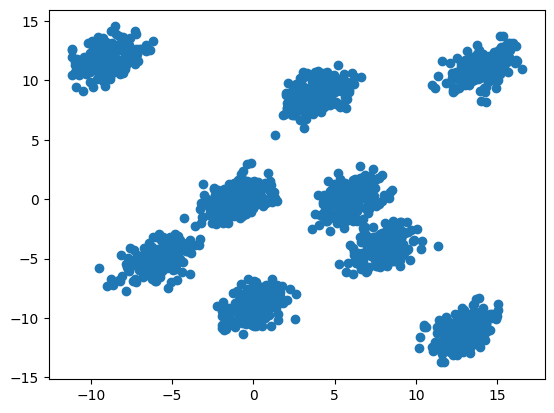

In [16]:
for csv in [f'data_{i}.csv' for i in range(4, 5)]:
    df = pd.read_csv(f'sinteticos/{csv}')
    plt.scatter(df['x'], df['y'],)
    plt.show()

# K-Means 2 aproximativo guloso

In [18]:
def greedy_k_means(data, k, type=2):
    def dist(p1, p2):
        """Minkowski distance between two points"""
        p = np.array([p1[0], p1[1]])
        q = np.array([p2[0], p2[1]])
        return np.linalg.norm(p - q, type)
    
    def closest(p, centers,):
        """"Return the index of the closest center to a point"""
        d = [dist(p, c) for c in centers]
        return np.argmin(d), min(d)
    
    centers = []
    centers.append(data.sample().values[0,:2])
    while len(centers) < k:
        #data['closest_i'] = data.apply(lambda x: closest(x.values[:2], centers), axis=1)
        data['closest'] = data.apply(lambda x: closest(x.values[:2], centers)[1], axis=1)
        pos = data['closest'].argmax()
        centers += [data.iloc[pos].values[:2]]
    else:
        data['closest_i'] = data.apply(lambda x: closest(x.values[:2], centers)[0], axis=1)
        data['closest'] = data.apply(lambda x: dist(x.values[:2], centers[int(x['closest_i'])]), axis=1)

    return centers, data['closest'].max(), data['closest_i']

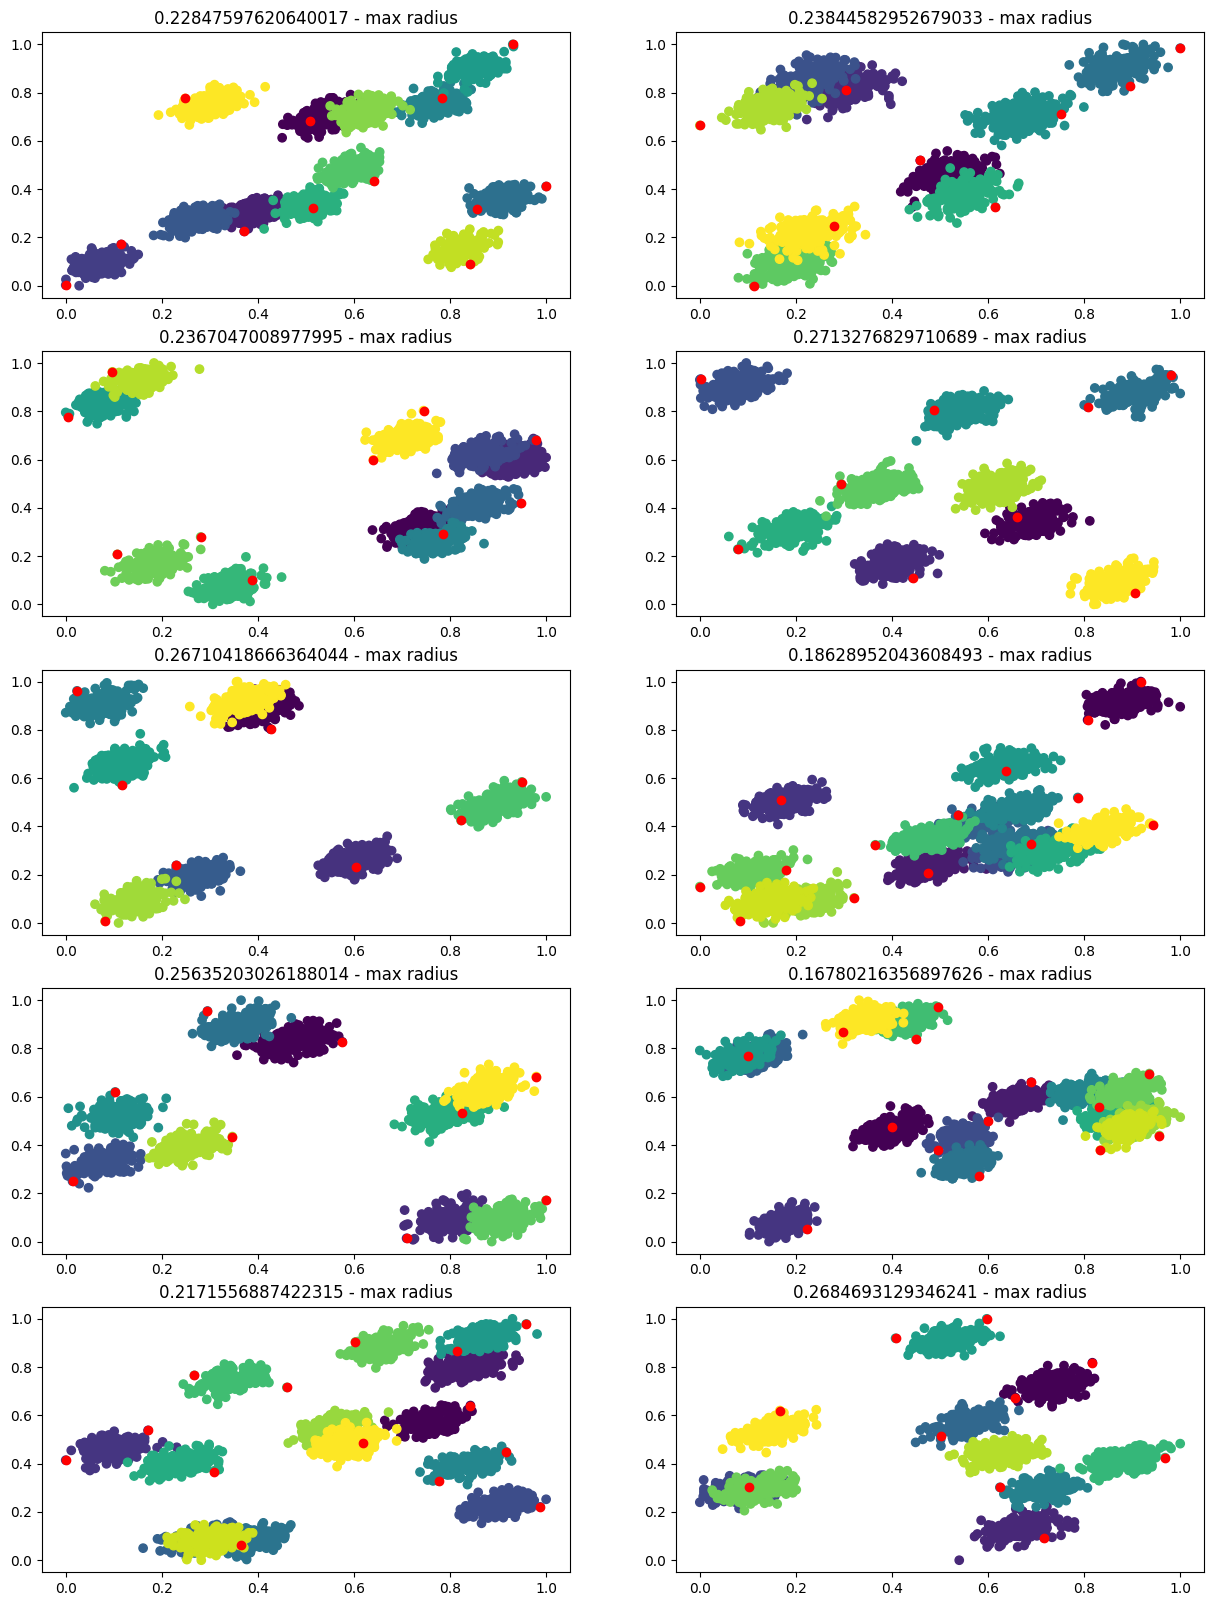

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))
predict = 0


for i,csv in enumerate([f'data_{i+1}.csv' for i in range(10)]):
    df = pd.read_csv(f'sinteticos/{csv}')
    for column in df.columns[:2]:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    n = len(df['label'].unique())
    centers, max_r, predict  = greedy_k_means(df, n,1)

    ax[i//2,i%2].scatter(df['x'], df['y'], c=df['label'])
    ax[i//2,i%2].scatter([c[0] for c in centers], [c[1] for c in centers], c='red')
    ax[i//2,i%2].set_title(f'{max_r} - max radius')

plt.show()

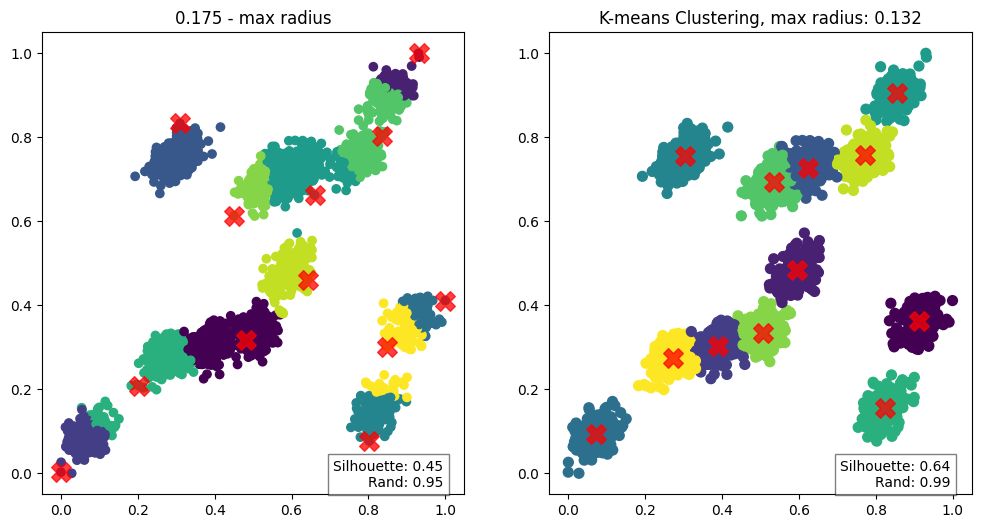

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score

df = pd.read_csv(f'sinteticos/data_{1}.csv')
for column in df.columns[:2]:
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
# Configurar o tamanho da figura
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Parte 1: Algoritmo greedy_k_means
n = len(df['label'].unique())
centers, max_r, predict = greedy_k_means(df, n, 2)
ss = silhouette_score(df.iloc[:,:2], predict)
rs = rand_score(df['label'], predict)

# Plotar o resultado do greedy_k_means
ax[0].scatter(df['x'], df['y'], c=predict)
ax[0].scatter([c[0] for c in centers], [c[1] for c in centers], c='red', s=200, alpha=0.75, marker='X')
ax[0].set_title(f'{max_r:.3f} - max radius')
ax[0].text(0.95, 0.01, f'Silhouette: {ss:.2f}\nRand: {rs:.2f}',
           verticalalignment='bottom', horizontalalignment='right',
           transform=ax[0].transAxes, color='black', fontsize=10,
           bbox=dict(facecolor='white', alpha=0.5))

# Parte 2: K-means do sklearn
X, y = df.iloc[:, :2], df['label']
kmeans = KMeans(n_clusters=len(y.unique()), random_state=42)
labels = kmeans.fit_predict(X)
distance = lambda x1, x2: ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)**0.5
mar_r_sklearn = max([distance(j,kmeans.cluster_centers_[labels[i]]) for i,j in enumerate(X.values[:,:2])])

# Imprimir métricas
sil_score = silhouette_score(X.values, labels)
rand_score_value = rand_score(y, labels)

# Plotar o resultado do K-means
ax[1].scatter(X.values[:, 0], X.values[:, 1], c=labels, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
ax[1].scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
ax[1].text(0.95, 0.01, f'Silhouette: {sil_score:.2f}\nRand: {rand_score_value:.2f}',
           verticalalignment='bottom', horizontalalignment='right',
           transform=ax[1].transAxes, color='black', fontsize=10,
           bbox=dict(facecolor='white', alpha=0.5))
# Configurar título e rótulos
ax[1].set_title(f'K-means Clustering, max radius: {mar_r_sklearn:.3f}')

# Exibir os gráficos
plt.show()

# Gerando metricas

In [21]:
type=2

In [22]:
metrics = []
csv_files = [f'data_{i+1}.csv' for i in range(10)]
for i,csv in enumerate(tqdm(csv_files)):
    df = pd.read_csv(f'sinteticos/{csv}')
    for column in df.columns[:2]:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

    n = len(df['label'].unique())
    radius = []
    times = []
    sillhouette_s = []
    rand_s = []
    for j in range(30):
        start = time.time()
        centers, max_r, predict = greedy_k_means(df, n,type)
        end = time.time()
        radius.append(max_r)
        times.append(end-start)
        sillhouette_s.append(silhouette_score(df.iloc[:,:2], predict))
        rand_s.append(rand_score(df['label'], predict))
    
    mean_radius = np.mean(radius)
    mean_time = np.mean(times)
    mean_sillhouette_s = np.mean(sillhouette_s)
    mean_rand_s = np.mean(rand_s)
    
    std_radius = np.std(radius)
    std_sillhouette_s = np.std(sillhouette_s)
    std_rand_s = np.std(rand_s)
    
    metrics.append([mean_radius, std_radius, mean_time, mean_sillhouette_s, std_sillhouette_s, mean_rand_s, std_rand_s])

df_greedy = pd.DataFrame(metrics, columns=['mean_radius', 'std_radius', 'mean_time', 'mean_sillhouette_s', 'std_sillhouette_s', 'mean_rand_s', 'std_rand_s'])

100%|██████████| 10/10 [03:57<00:00, 23.76s/it]


In [23]:
df_greedy.to_csv(f'sinteticos/greedy_metrics_{type}.csv', index=False)
df_greedy

,mean_radius,std_radius,mean_time,mean_sillhouette_s,std_sillhouette_s,mean_rand_s,std_rand_s
0,0.175236,0.012309,0.839114,0.477391,0.049245,0.942498,0.010731
1,0.208861,0.010823,0.417490,0.422181,0.040885,0.930487,0.011196
2,0.180214,0.010770,0.523742,0.466664,0.034110,0.929496,0.020541
3,0.213408,0.004259,0.410175,0.694867,0.030984,0.980408,0.013393
4,0.200071,0.011575,0.316702,0.643135,0.033184,0.953844,0.009486
5,0.157947,0.011160,1.243586,0.394570,0.024298,0.926417,0.008080
6,0.195425,0.007621,0.418393,0.539678,0.018193,0.969341,0.010060
7,0.146579,0.009972,1.224631,0.377421,0.032022,0.933068,0.008161
8,0.178203,0.006152,1.209949,0.489341,0.041561,0.951411,0.006329
9,0.201471,0.015241,0.572125,0.478901,0.056534,0.928532,0.013224


In [24]:
metrics = []
csv_files = [f'data_{i+1}.csv' for i in range(10)]
for i,csv in enumerate(tqdm(csv_files)):
    df = pd.read_csv(f'sinteticos/{csv}')
    for column in df.columns[:2]:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    #print(df)
    X, y = df.iloc[:,:2], df['label']
    n = len(df['label'].unique())
    radius = []
    times = []
    sillhouette_s = []
    rand_s = []
    for j in range(30):
        start = time.time()
        kmeans = KMeans(n_clusters=len(y.unique()), random_state=42)
        labels = kmeans.fit_predict(X)
        #distance = lambda x1, x2: ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)**0.5
        distance = lambda x1, x2: np.sum(np.abs(x1 - x2)**type)**(1/type)
        mar_r_sklearn = max([distance(j,kmeans.cluster_centers_[labels[i]]) for i,j in enumerate(X.values[:,:2])])
        end = time.time()
        radius.append(mar_r_sklearn)
        times.append(end-start)
        sillhouette_s.append(silhouette_score(X.values, labels))
        rand_s.append(rand_score(y, labels))
    
    mean_radius = np.mean(radius)
    mean_time = np.mean(times)
    mean_sillhouette_s = np.mean(sillhouette_s)
    mean_rand_s = np.mean(rand_s)
    
    std_radius = np.std(radius)
    std_sillhouette_s = np.std(sillhouette_s)
    std_rand_s = np.std(rand_s)
    
    metrics.append([mean_radius, std_radius, mean_time, mean_sillhouette_s, std_sillhouette_s, mean_rand_s, std_rand_s])

df_sklearn = pd.DataFrame(metrics, columns=['mean_radius', 'std_radius', 'mean_time', 'mean_sillhouette_s', 'std_sillhouette_s', 'mean_rand_s', 'std_rand_s'])
df_sklearn.to_csv(f'sinteticos/sklearn_metrics_{type}.csv', index=False)
df_sklearn

100%|██████████| 10/10 [00:42<00:00,  4.25s/it]


,mean_radius,std_radius,mean_time,mean_sillhouette_s,std_sillhouette_s,mean_rand_s,std_rand_s
0,0.132084,0.000000e+00,0.049112,0.641315,3.330669e-16,0.989548,2.220446e-16
1,0.168114,4.299875e-17,0.077137,0.507378,1.110223e-16,0.969387,2.220446e-16
2,0.147805,2.775558e-17,0.058811,0.545232,1.110223e-16,0.982632,0.000000e+00
3,0.153844,5.551115e-17,0.065680,0.745933,0.000000e+00,0.999262,2.220446e-16
4,0.136488,5.551115e-17,0.070165,0.644060,1.110223e-16,0.966886,2.220446e-16
5,0.127504,2.775558e-17,0.025355,0.512045,0.000000e+00,0.963944,1.110223e-16
6,0.124548,2.775558e-17,0.061553,0.580904,1.110223e-16,0.988027,2.220446e-16
7,0.134056,0.000000e+00,0.029068,0.505451,1.110223e-16,0.957697,2.220446e-16
8,0.123871,4.163336e-17,0.026064,0.560862,2.220446e-16,0.978110,2.220446e-16
9,0.186429,2.775558e-17,0.060210,0.668528,0.000000e+00,0.974079,3.330669e-16
